In [417]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import csv
import pandas as pd

from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score
from sklearn.preprocessing import normalize, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

def gridSearch(model, parameters, x, y):
    scorer = make_scorer(mean_squared_error)
    model = GridSearchCV(model, param_grid=parameters, scoring=scorer)
    model = model.fit(x, y)
    sorted(model.cv_results_.keys())
    return model

def randomSearch(model, parameters, x, y):
    scorer = make_scorer(mean_squared_error)
    model = RandomizedSearchCV(model, scoring=scorer, param_distributions=parameters)
    #model = rSearch.fit(x, y)
    print("Best score: ", model.best_score_)
    print("Best parameters: ", model.best_params_)
    return model

def plotResults(x, y, x_label, y_label, title):
    plt.scatter(x, y)
    plt.title(title, fontsize=18)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)
    plt.grid('on')
    title+=".png"
    path = "graphs_beta"
    path += title
    plt.savefig(path)

def getRasterMean(path):
    with rasterio.open(path) as raster:
        raster_data = raster.read(1)
        mean_value = raster_data.mean()
    return mean_value

def getRasterMeanDifference(path_before, path_after):
    with rasterio.open(path_before) as raster:
        raster_data = raster.read(1)
        mean_before = raster_data.mean()
    with rasterio.open(path_after) as raster:
        raster_data = raster.read(1)
        mean_after = raster_data.mean()
    return mean_before - mean_after

def plotRaster(path):
    with rasterio.open(path) as raster:
        raster_data = raster.read(1)
        plt.imshow(raster_data, cmap='Greens')
        plt.colorbar(label='Pixel values')
        plt.title(label=path)
        plt.show()

In [418]:
filename = './other_data/CAFloodLossInputNumerical.csv'
file = open(filename, 'rt')
reader = csv.reader(file, delimiter=',')
x = list(reader)
data = np.array(x)

In [419]:
header, raw_data = np.vsplit(data, [1])
raw_x, raw_y = np.hsplit(raw_data, [8])
print(raw_x.shape, raw_y.shape)
#categorical_data, num_data = np.hsplit(raw_x, [1])


# encoder = OneHotEncoder()
# encx = encoder.fit_transform(categorical_data)

#print(categorical_data)
#print(categorical_encoded)
# print(encoder.fit(categorical_data))
#print(pd.get_dummies(categorical_data.ravel()))



(132, 8) (132, 1)


In [420]:
x_train, x_test, y_train, y_test = train_test_split(raw_x, raw_y)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

y_train = y_train.ravel().astype(float)
y_test = y_test.ravel().astype(float)

print(x_train_scaled.shape)
print(x_test_scaled.shape)
print(y_train.shape)

(99, 8)
(33, 8)
(99,)


In [402]:
x_nvdi = np.zeros([26])
y_data = np.zeros([26])

x_precipitation = np.loadtxt("./other_data/precipitation.csv", delimiter=",", dtype=int)
print(x_precipitation)

for i in range(0, 26):
    path_before = 'raster_maps/' + str(i) + '_before.tif'
    path_after = 'raster_maps/' + str(i) + '_after.tif'
    x_nvdi[i] = getRasterMean(path_before)
    y_data[i] = getRasterMeanDifference(path_before, path_after)

[ 27  27  27  27  27 313 313 313 313 313 313 313 313 313 313 454 454 454
 454 454 454 454 454 454 454  27]


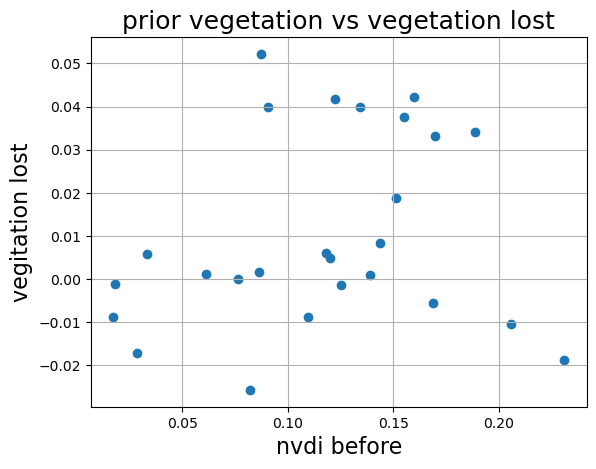

In [403]:
plotResults(x_nvdi, y_data, "nvdi before", "vegitation lost", "prior vegetation vs vegetation lost")

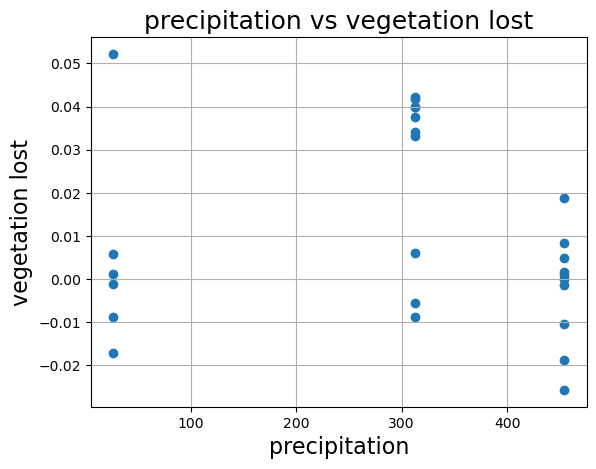

In [404]:
plotResults(x_precipitation, y_data, "precipitation", "vegetation lost", "precipitation vs vegetation lost")

In [405]:
x_data = np.vstack((x_nvdi, x_precipitation)).T
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)
print(x_test[0][0])


0.10955806076526642


In [397]:
reg = LinearRegression().fit(x_train_scaled, y_train)
reg.score(x_test_scaled, y_test)
print(x_test_scaled)


[[ 2.17314251  0.50097935]
 [-0.27556392  0.87072265]
 [-0.8363918  -2.05298825]
 [-0.51173172  0.87072265]
 [-0.0636054  -0.09471819]
 [-0.48584967 -0.09471819]]


In [395]:
input_value = getRasterMean("./raster_maps/test.tiff")
x_test[0][0] = input_value
x_test[0][1] = 400
x_test_scaled = scaler.fit_transform(x_test)
output_value = reg.predict(x_test_scaled)
print(output_value)

[ 0.02938624 -0.00252079  0.02110565 -0.00523141  0.00983922  0.00499289]


In [407]:
y_predict = reg.predict(x_test_scaled)
print(reg.score(x_test_scaled, y_test))
mse = mean_squared_error(y_test, y_predict)
print(mse)
#plotResults(y_test, y_predict, "Actual Values", "Predicted Values", "Actual vs Predicted")

0.21929664569110052
0.00031546220088241793


In [411]:
cValues = np.linspace(.1, 1, 20, dtype=float)
parameters = {"kernel": ["linear", 'poly'], "C": cValues}
svr = svm.SVR()
svrLinearModel = gridSearch(svr, parameters, x_train_scaled, y_train)
print(svrLinearModel.best_score_)
print(svrLinearModel.best_params_)

0.0005640025841357425
{'C': 0.1, 'kernel': 'linear'}


In [412]:
mean_scores = svrLinearModel.cv_results_['mean_test_score']
#print(mean_scores.shape())
mean_scores = np.delete(mean_scores, [0,1])
print(mean_scores)
x_cValues = np.delete(cValues, [0,1])
print(x_cValues.shape)
#plotResults(x_cValues, mean_scores, "c values", "Scores", "Linear: c values vs mean score")

[0.000564 0.000564 0.000564 0.000564 0.000564 0.000564 0.000564 0.000564
 0.000564 0.000564 0.000564 0.000564 0.000564 0.000564 0.000564 0.000564
 0.000564 0.000564 0.000564 0.000564 0.000564 0.000564 0.000564 0.000564
 0.000564 0.000564 0.000564 0.000564 0.000564 0.000564 0.000564 0.000564
 0.000564 0.000564 0.000564 0.000564 0.000564 0.000564]
(18,)


In [416]:
model = svm.SVR(C=0.1, kernel='linear')
model.fit(x_train_scaled, y_train)
y_predict = model.predict(x_test_scaled)
mse = mean_squared_error(y_test, y_predict)
print(mse)

0.0004040760043126952


In [383]:
n_estimators = np.linspace(1, 1000, 10, dtype=int)
max_features = ["sqrt", "log2", None]
parameters = {"n_estimators": n_estimators, "max_features": max_features}
model = RandomForestRegressor()
model = gridSearch(model, parameters, x_train_scaled, y_train)
model.fit(x_train_scaled, y_train)
print(model.score(x_test_scaled, y_test))
y_predict = model.predict(x_test_scaled)
#print(y_predict)
mse = mean_squared_error(y_test, y_predict)
print(mse)

88528259356.09256
88528259356.09256


In [362]:
print(model.best_params_)
#complex dataset: max features none n_estimators: 1

{'max_features': None, 'n_estimators': 1}
